# Init

/Users/justin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


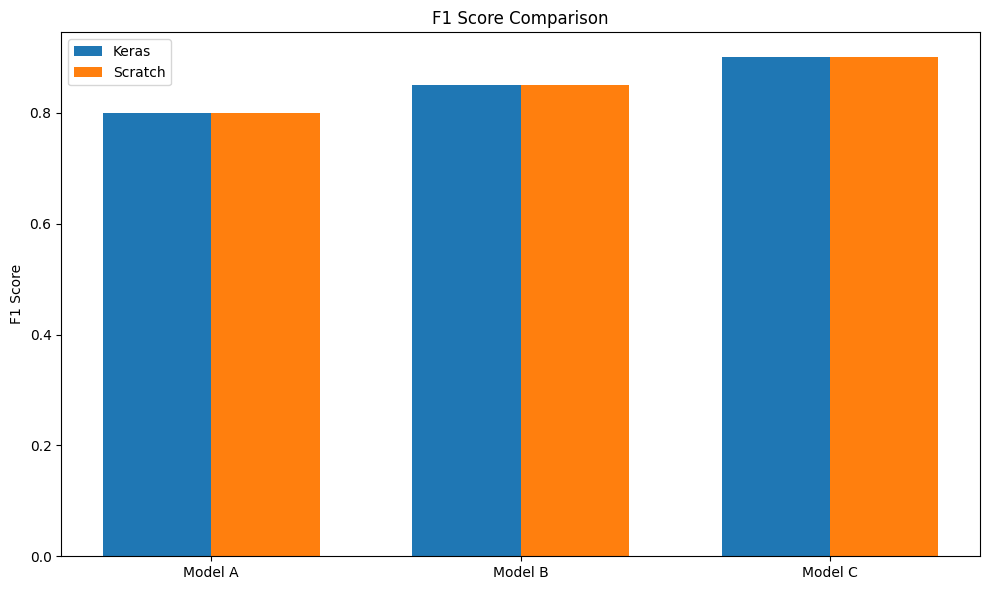

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam


from layers.embedding import EmbeddingLayer
from layers.lstm.bidirectionalLSTM import BidirectionalLSTM
from layers.lstm.unidirectionalLSTM import UnidirectionalLSTM
from layers.dropout import DropoutLayer
from layers.dense import DenseLayer

from model_scratch.model import Model
from model_scratch.lstm import LSTM as LSTMModel
from utils.evaluate import evaluate_model
from utils.visualize import visualize_loss, visualize_f1, visualize_train_val_loss

from sklearn.metrics import f1_score
import random

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
valid = pd.read_csv('data/valid.csv')
train['label'] = train['label'].map({'neutral': 0, 'positive': 1, 'negative': 2}).astype(np.float32)
test['label'] = test['label'].map({'neutral': 0, 'positive': 1, 'negative': 2}).astype(np.float32)
valid['label'] = valid['label'].map({'neutral': 0, 'positive': 1, 'negative': 2}).astype(np.float32)

# Set random seed for reproducibility
seed = 42
random.seed(seed)                         # python random
np.random.seed(seed)                      # numpy
tf.random.set_seed(seed)   

In [3]:
tokenizer = Tokenizer(oov_token="<UNK>")  # Reserve a token for unknown words
tokenizer.fit_on_texts(train['text'].values) 
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding (index 0 is reserved)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 2796


In [4]:
embedding_dim = 50 # Dimension of the embedding layer
max_length = 60  # Maximum length of input sequences

train_sequences = tokenizer.texts_to_sequences(train['text'].values)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
valid_sequences = tokenizer.texts_to_sequences(valid['text'].values)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding='post', truncating='post')
test_sequences = tokenizer.texts_to_sequences(test['text'].values)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

vocab_size = len(tokenizer.word_index) + 1  # +1 for padding (index 0 is reserved)

95th Percentile Length: 54.0
98th Percentile Length: 59.0


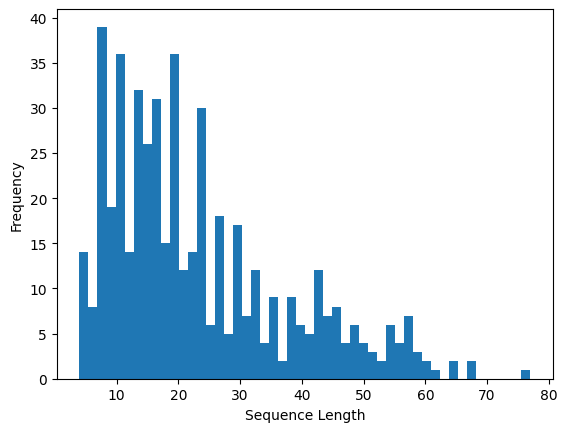

In [5]:
import matplotlib.pyplot as plt
lengths = [len(seq) for seq in tokenizer.texts_to_sequences(train['text'].values)]
percentile_95 = np.percentile(lengths, 95)
percentile_98 = np.percentile(lengths, 98)
print(f"95th Percentile Length: {percentile_95}")
print(f"98th Percentile Length: {percentile_98}")
plt.hist(lengths, bins=50)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

In [6]:
print(f"Train padded shape: {train_padded.shape}")
print(f"Valid padded shape: {valid_padded.shape}")
print(f"Test padded shape: {test_padded.shape}")

Train padded shape: (500, 60)
Valid padded shape: (100, 60)
Test padded shape: (400, 60)


In [7]:
def get_weights_per_layer(model, verbose=True):
    all_weights = []
    for layer in model.layers:
        if verbose:
            print(f"Layer: {layer.name}") 
        weights = layer.get_weights()
        all_weights.append(weights)
        if verbose:
            for i, w in enumerate(weights):
                print(f"  Weight {i}: shape {w.shape}")
    return all_weights

# Pengaruh Jumlah Layer LSTM

In [8]:
val_loss = []
train_loss = []
scores = []
scores_scratch = []

## 1 layer LSTM

In [9]:
# Build the model
layer1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(units=8, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Dense(3, activation='softmax')  # for binary classification (e.g., sentiment)
])

# Compile the model
layer1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = layer1.fit(
    train_padded,
    train['label'].values,
    validation_data=(valid_padded, valid['label'].values),
    epochs=10,          # number of passes over the data, adjust as needed
    batch_size=32,      # number of samples per batch, adjust as needed
    verbose=0          # verbosity mode, 0 = silent, 1 = progress bar, 2 = one line per epoch
)

train_loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

all_weights = get_weights_per_layer(layer1, verbose=False)


# Evaluate the model
score_1_layer = evaluate_model(layer1, test_padded, test['label'])
scores.append(score_1_layer)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Macro F1 Score: 0.4910


In [10]:
layer1Scratch = LSTMModel([
    EmbeddingLayer(vocab_size, embedding_dim),
    UnidirectionalLSTM(8, return_sequences=False, activation='tanh'),
    DropoutLayer(0.5),
    DenseLayer(3, 8, activation='softmax', init_method='zeros')
], 32)

layer1Scratch.load_weights(all_weights)

# Evaluate the model
score_1_layer_scratch = evaluate_model(layer1Scratch, test_padded, test['label'])
scores_scratch.append(score_1_layer_scratch)

Predicting with batch size: 32, input shape: (400, 60)
Macro F1 Score: 0.4910


## 2 Layer LSTM

In [11]:
# Build the model
layer2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(units=8, activation='tanh', return_sequences=True),
    LSTM(units=8, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Dense(3, activation='softmax')  # for 3-class classification (sentiment)
])

# Compile the model
layer2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = layer2.fit(
    train_padded,
    train['label'].values,
    validation_data=(valid_padded, valid['label'].values),
    epochs=10,          # number of passes over the data, adjust as needed
    batch_size=32,      # number of samples per batch, adjust as needed
    verbose=0          # verbosity mode, 0 = silent, 1 = progress bar, 2 = one line per epoch
)

train_loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

all_weights = get_weights_per_layer(layer2, verbose=False)

# Evaluate the model
score_2_layer = evaluate_model(layer2, test_padded, test['label'])
scores.append(score_2_layer)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Macro F1 Score: 0.4576


In [12]:
layer2Scratch = LSTMModel([
    EmbeddingLayer(vocab_size, embedding_dim),
    UnidirectionalLSTM(8, return_sequences=True, activation='tanh'),
    UnidirectionalLSTM(8, return_sequences=False, activation='tanh'),
    DropoutLayer(0.5),
    DenseLayer(3, 8, activation='softmax', init_method='zeros')
], 32)

layer2Scratch.load_weights(all_weights)

# Evaluate the model
score_2_layer_scratch = evaluate_model(layer2Scratch, test_padded, test['label'])
scores_scratch.append(score_2_layer_scratch)

Predicting with batch size: 32, input shape: (400, 60)
Macro F1 Score: 0.4576


## 3 Layer LSTM


In [13]:
# Build the model
layer3 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(units=8, activation='tanh', return_sequences=True),
    LSTM(units=8, activation='tanh', return_sequences=True),
    LSTM(units=8, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Dense(3, activation='softmax')  # for binary classification (e.g., sentiment)
])

# Compile the model
layer3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = layer3.fit(
    train_padded,
    train['label'].values,
    validation_data=(valid_padded, valid['label'].values),
    epochs=10,          # number of passes over the data, adjust as needed
    batch_size=32,      # number of samples per batch, adjust as needed
    verbose=0          # verbosity mode, 0 = silent, 1 = progress bar, 2 = one line per epoch
)

train_loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

all_weights = get_weights_per_layer(layer3, verbose=False)

# Evaluate the model
score_3_layer = evaluate_model(layer3, test_padded, test['label'])
scores.append(score_3_layer)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Macro F1 Score: 0.5419


In [14]:
layer3Scratch = LSTMModel([
    EmbeddingLayer(vocab_size, embedding_dim),
    UnidirectionalLSTM(8, return_sequences=True, activation='tanh'),
    UnidirectionalLSTM(8, return_sequences=True, activation='tanh'),
    UnidirectionalLSTM(8, return_sequences=False, activation='tanh'),
    DropoutLayer(0.5),
    DenseLayer(3, 8, activation='softmax', init_method='zeros')
], 32)

layer3Scratch.load_weights(all_weights)

# Evaluate the model
score_3_layer_scratch = evaluate_model(layer3Scratch, test_padded, test['label'])
scores_scratch.append(score_3_layer_scratch)

Predicting with batch size: 32, input shape: (400, 60)
Macro F1 Score: 0.5419


Score for Layer 1:
  F1 Score: 0.4910321516586647
Score for Layer 2:
  F1 Score: 0.4576372909181436
Score for Layer 3:
  F1 Score: 0.5418736714242333
Score for Layer 1 Scratch:
  F1 Score: 0.4910321516586647
Score for Layer 2 Scratch:
  F1 Score: 0.4576372909181436
Score for Layer 3 Scratch:
  F1 Score: 0.5418736714242333
Train Loss for Layer 1: [1.0979746580123901, 1.087661862373352, 1.086354374885559, 1.0823355913162231, 1.0814377069473267, 1.0824319124221802, 1.0701591968536377, 1.0652738809585571, 0.9975095391273499, 0.8703471422195435]
Train Loss for Layer 2: [1.097004771232605, 1.0888625383377075, 1.0865248441696167, 1.0895130634307861, 1.0839762687683105, 1.0817136764526367, 1.0783755779266357, 1.0765790939331055, 1.0687971115112305, 1.0171784162521362]
Train Loss for Layer 3: [1.0975159406661987, 1.0916180610656738, 1.0855774879455566, 1.0812424421310425, 1.0794299840927124, 1.0749585628509521, 1.050866723060608, 1.0231640338897705, 0.9848358035087585, 0.923085629940033]
Valida

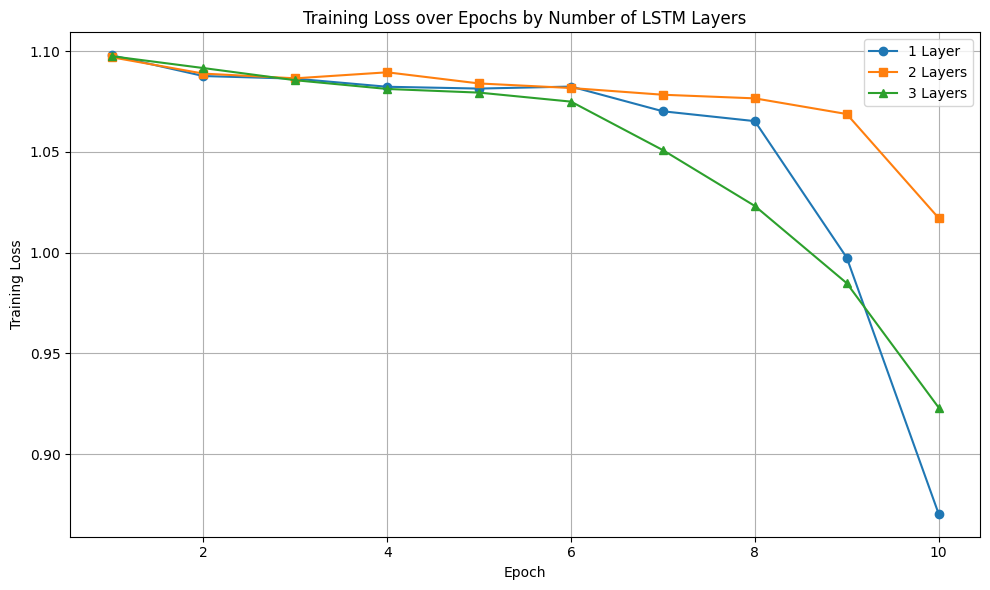

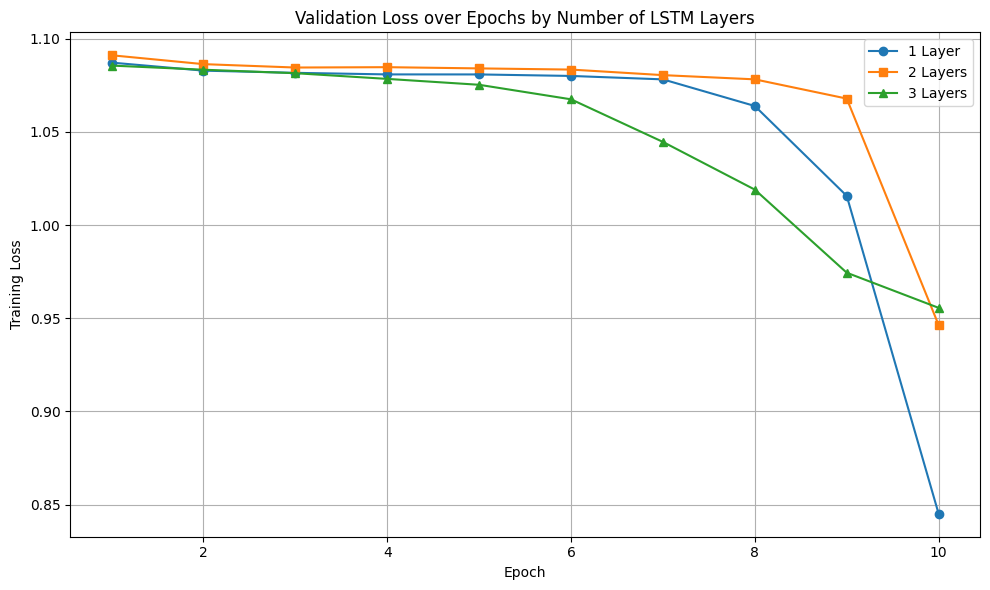

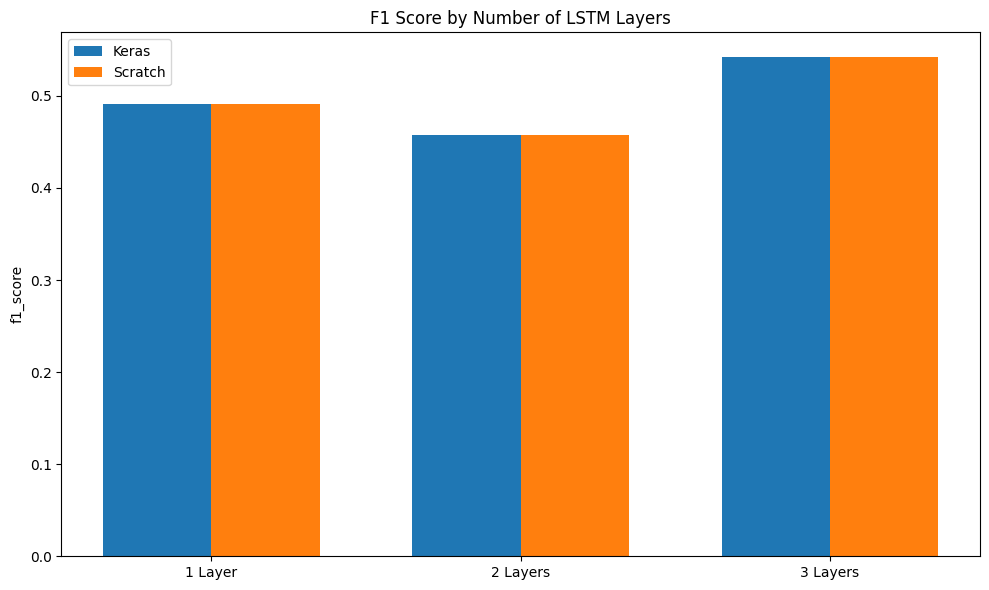

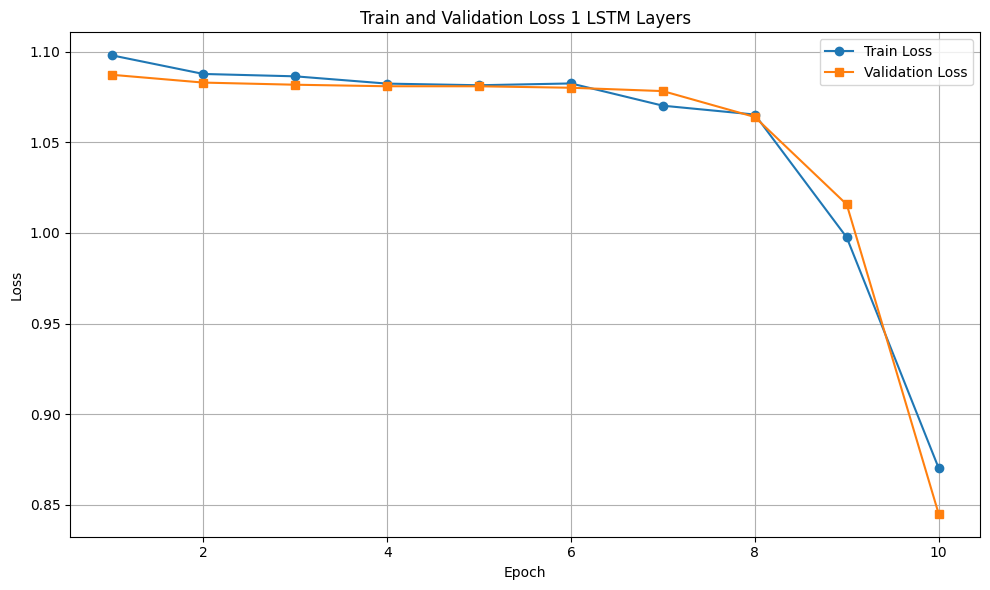

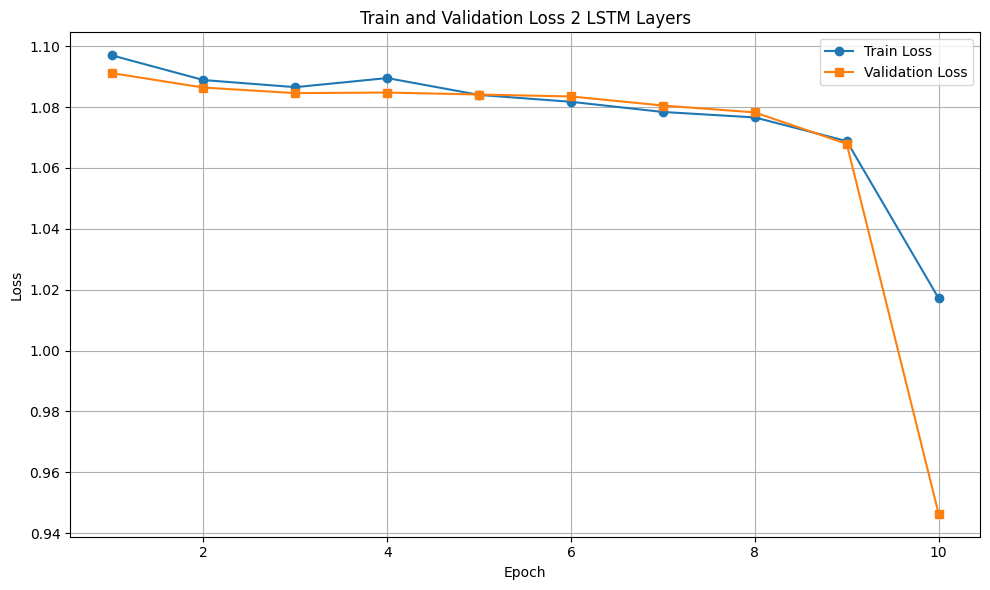

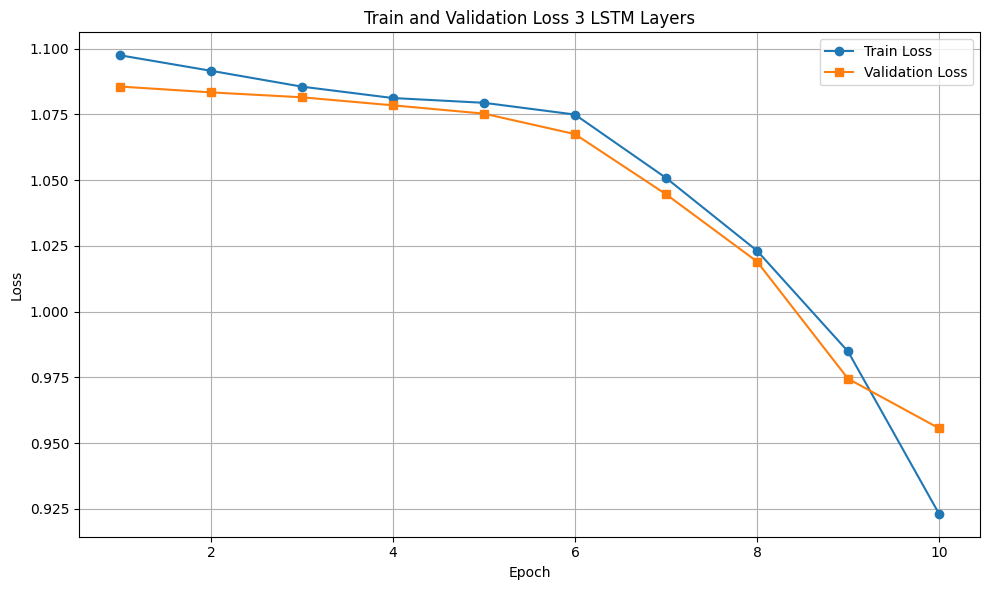

In [15]:
for i, score in enumerate(scores):
    print(f"Score for Layer {i+1}:")
    print(f"  F1 Score: {score}")

for i, score in enumerate(scores_scratch):
    print(f"Score for Layer {i+1} Scratch:")
    print(f"  F1 Score: {score}")

for i, loss in enumerate(train_loss):
    print(f"Train Loss for Layer {i+1}: {loss}")

for i, loss in enumerate(val_loss):
    print(f"Validation Loss for Layer {i+1}: {loss}")

visualize_loss(list(range(1, len(train_loss[0])+1)), train_loss, ['1 Layer', '2 Layers', '3 Layers'], 'Training Loss over Epochs by Number of LSTM Layers')
visualize_loss(list(range(1, len(val_loss[0])+1)), val_loss, ['1 Layer', '2 Layers', '3 Layers'], 'Validation Loss over Epochs by Number of LSTM Layers')
visualize_f1(scores, scores_scratch, ['1 Layer', '2 Layers', '3 Layers'], title='F1 Score by Number of LSTM Layers')
visualize_train_val_loss(train_loss=train_loss[0], val_loss=val_loss[0], epochs=list(range(1, len(train_loss[0])+1)), title='Train and Validation Loss 1 LSTM Layers')
visualize_train_val_loss(train_loss=train_loss[1], val_loss=val_loss[1], epochs=list(range(1, len(train_loss[1])+1)), title='Train and Validation Loss 2 LSTM Layers')
visualize_train_val_loss(train_loss=train_loss[2], val_loss=val_loss[2], epochs=list(range(1, len(train_loss[2])+1)), title='Train and Validation Loss 3 LSTM Layers')

# Pengaruh Banyak Cell LSTM per Layer

In [16]:
val_loss = []
train_loss = []
scores = []
scores_scratch = []

## 8 Cell

In [17]:
# Build the model
cell8 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(units=8, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Dense(3, activation='softmax')  # for binary classification (e.g., sentiment)
])

# Compile the model
cell8.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = cell8.fit(
    train_padded,
    train['label'].values,
    validation_data=(valid_padded, valid['label'].values),
    epochs=10,          # number of passes over the data, adjust as needed
    batch_size=32,      # number of samples per batch, adjust as needed
    verbose=0          # verbosity mode, 0 = silent, 1 = progress bar, 2 = one line per epoch
)

train_loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

all_weights = get_weights_per_layer(cell8, verbose=False)


# Evaluate the model
score_8_cell = evaluate_model(cell8, test_padded, test['label'])
scores.append(score_8_cell)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Macro F1 Score: 0.1844


In [18]:
cell8Scratch = LSTMModel([
    EmbeddingLayer(vocab_size, embedding_dim),
    UnidirectionalLSTM(8, return_sequences=False, activation='tanh'),
    DropoutLayer(0.5),
    DenseLayer(3, 8, activation='softmax', init_method='zeros')
], 32)

cell8Scratch.load_weights(all_weights)

# Evaluate the model
score_8_cell_scratch = evaluate_model(cell8Scratch, test_padded, test['label'])
scores_scratch.append(score_8_cell_scratch)

Predicting with batch size: 32, input shape: (400, 60)
Macro F1 Score: 0.1844


## 16 Cell

In [19]:
# Build the model
cell16 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(units=16, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Dense(3, activation='softmax')  # for binary classification (e.g., sentiment)
])

# Compile the model
cell16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = cell16.fit(
    train_padded,
    train['label'].values,
    validation_data=(valid_padded, valid['label'].values),
    epochs=10,          # number of passes over the data, adjust as needed
    batch_size=32,      # number of samples per batch, adjust as needed
    verbose=0          # verbosity mode, 0 = silent, 1 = progress bar, 2 = one line per epoch
)

train_loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

all_weights = get_weights_per_layer(cell16, verbose=False)


# Evaluate the model
score_16_cell = evaluate_model(cell16, test_padded, test['label'])
scores.append(score_16_cell)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Macro F1 Score: 0.4993


In [20]:
cell16Scratch = LSTMModel([
    EmbeddingLayer(vocab_size, embedding_dim),
    UnidirectionalLSTM(16, return_sequences=False, activation='tanh'),
    DropoutLayer(0.5),
    DenseLayer(3, 16, activation='softmax', init_method='zeros')
], 32)

cell16Scratch.load_weights(all_weights)

# Evaluate the model
score_16_cell_scratch = evaluate_model(cell16Scratch, test_padded, test['label'])
scores_scratch.append(score_16_cell_scratch)

Predicting with batch size: 32, input shape: (400, 60)
Macro F1 Score: 0.4993


## 24 Cell

In [21]:
# Build the model
cell24 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(units=24, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Dense(3, activation='softmax')  # for binary classification (e.g., sentiment)
])

# Compile the model
cell24.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = cell24.fit(
    train_padded,
    train['label'].values,
    validation_data=(valid_padded, valid['label'].values),
    epochs=10,          # number of passes over the data, adjust as needed
    batch_size=32,      # number of samples per batch, adjust as needed
    verbose=0          # verbosity mode, 0 = silent, 1 = progress bar, 2 = one line per epoch
)

train_loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

all_weights = get_weights_per_layer(cell24, verbose=False)


# Evaluate the model
score_24_cell = evaluate_model(cell24, test_padded, test['label'])
scores.append(score_24_cell)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Macro F1 Score: 0.4765


In [22]:
cell24Scratch = LSTMModel([
    EmbeddingLayer(vocab_size, embedding_dim),
    UnidirectionalLSTM(24, return_sequences=False, activation='tanh'),
    DropoutLayer(0.5),
    DenseLayer(3, 24, activation='softmax', init_method='zeros')
], 32)

cell24Scratch.load_weights(all_weights)

# Evaluate the model
score_24_cell_scratch = evaluate_model(cell24Scratch, test_padded, test['label'])
scores_scratch.append(score_24_cell_scratch)

Predicting with batch size: 32, input shape: (400, 60)
Macro F1 Score: 0.4765


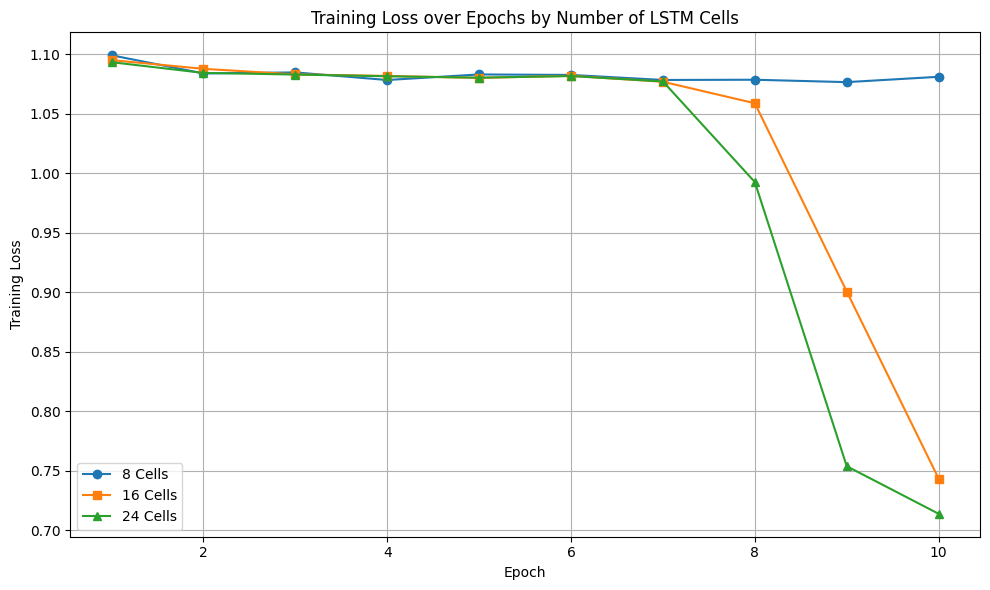

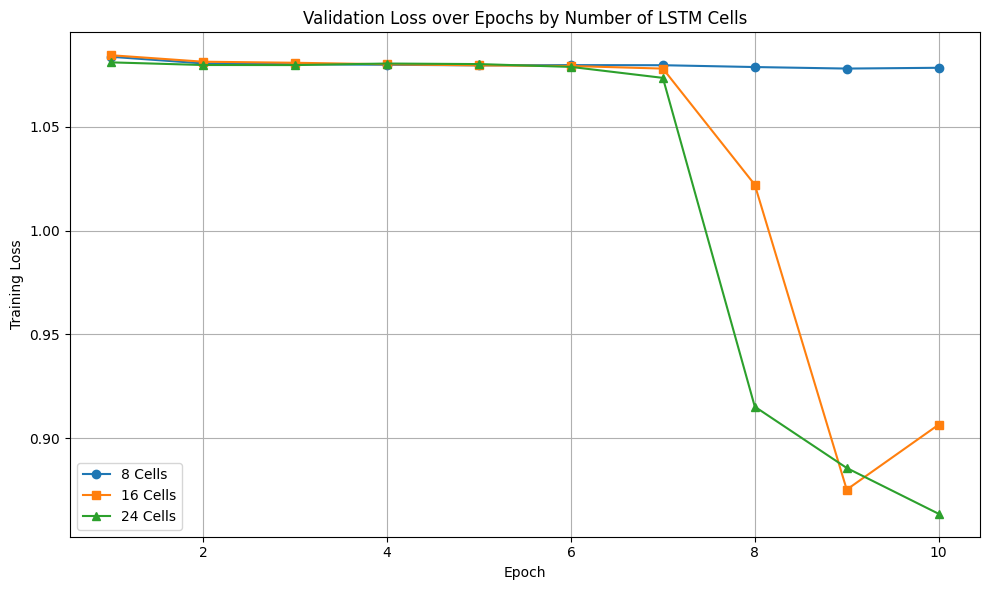

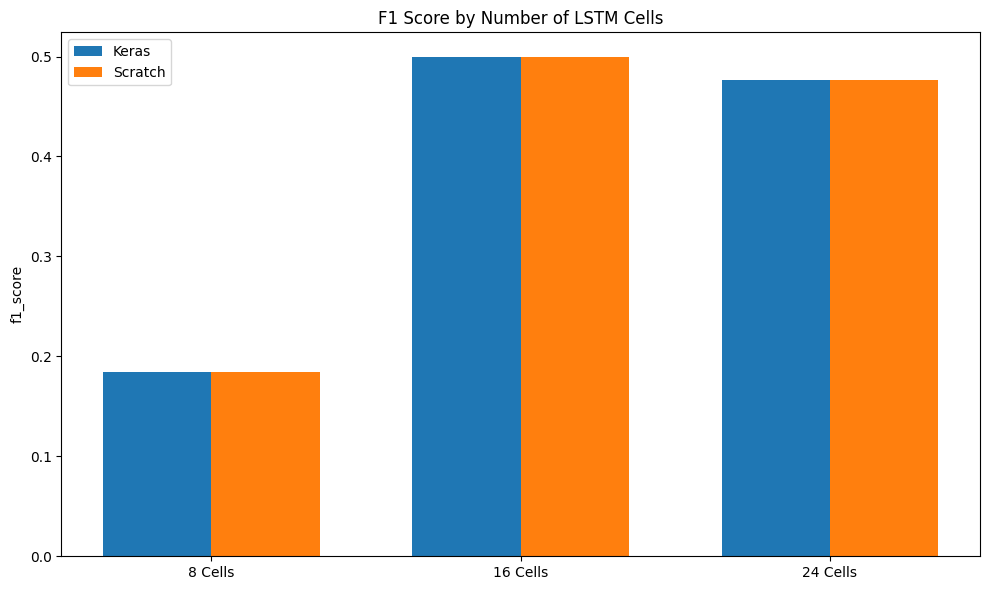

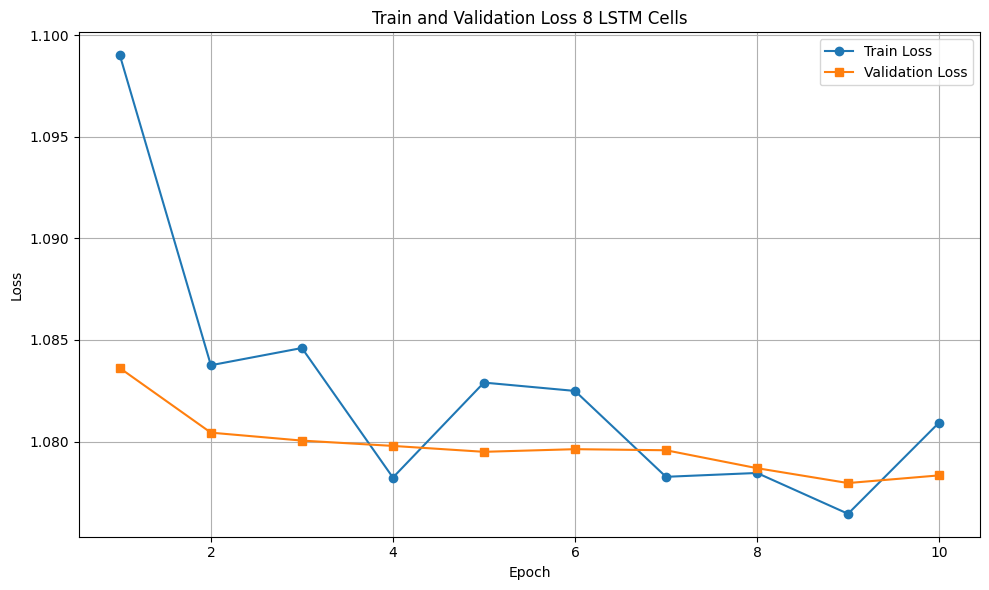

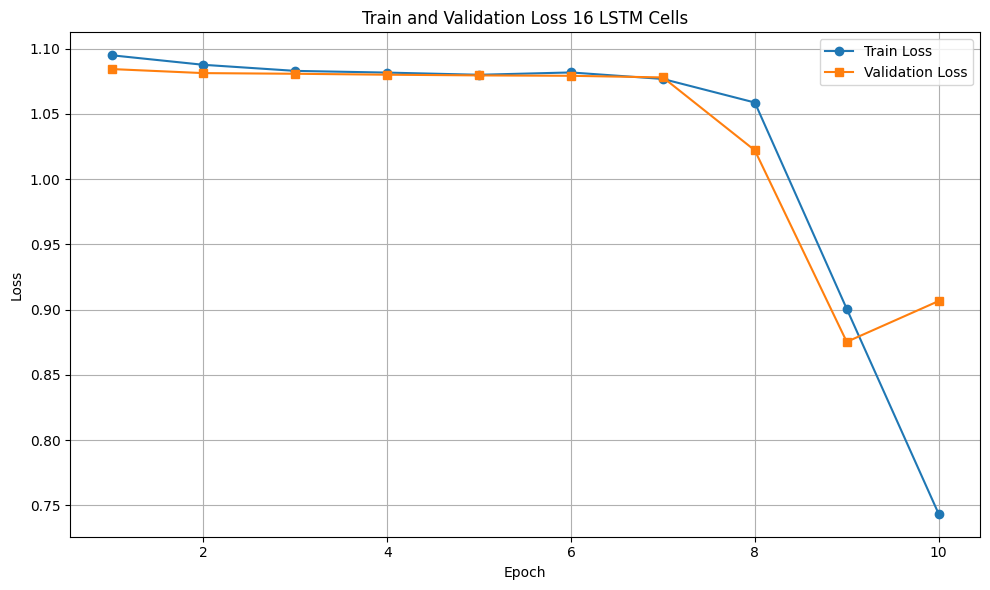

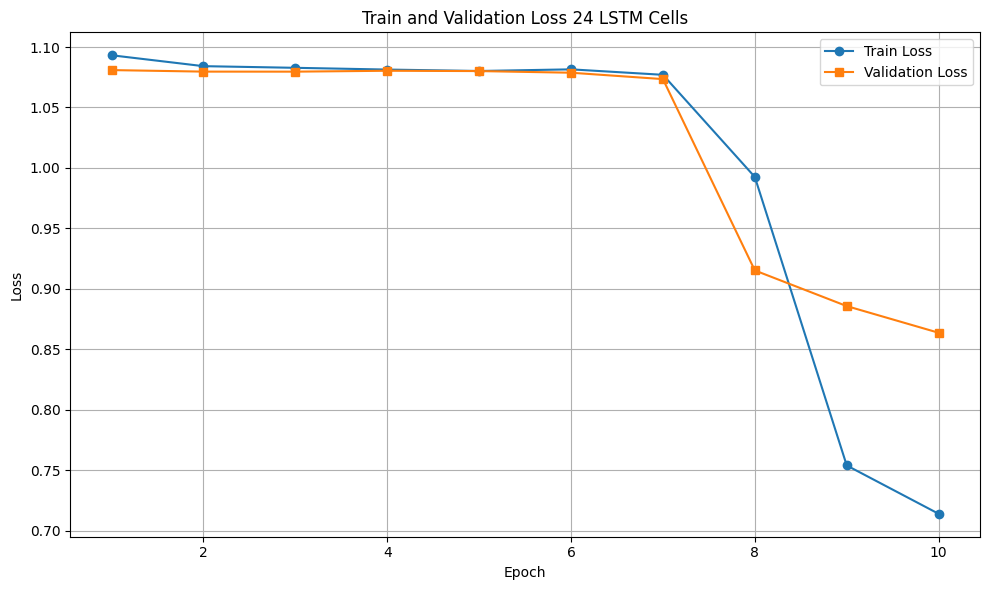

In [23]:
visualize_loss(list(range(1, len(train_loss[0])+1)), train_loss, ['8 Cells', '16 Cells', '24 Cells'], 'Training Loss over Epochs by Number of LSTM Cells')
visualize_loss(list(range(1, len(val_loss[0])+1)), val_loss, ['8 Cells', '16 Cells', '24 Cells'], 'Validation Loss over Epochs by Number of LSTM Cells')
visualize_f1(scores, scores_scratch, ['8 Cells', '16 Cells', '24 Cells'], title='F1 Score by Number of LSTM Cells')
visualize_train_val_loss(train_loss=train_loss[0], val_loss=val_loss[0], epochs=list(range(1, len(train_loss[0])+1)), title='Train and Validation Loss 8 LSTM Cells')
visualize_train_val_loss(train_loss=train_loss[1], val_loss=val_loss[1], epochs=list(range(1, len(train_loss[1])+1)), title='Train and Validation Loss 16 LSTM Cells')
visualize_train_val_loss(train_loss=train_loss[2], val_loss=val_loss[2], epochs=list(range(1, len(train_loss[2])+1)), title='Train and Validation Loss 24 LSTM Cells')

# Pengaruh jenis layer LSTM berdasarkan arah

In [24]:
val_loss = []
train_loss = []
scores = []
scores_scratch = []

## Unidirectional

In [25]:
# Build the model
layer1Uni = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(units=8, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Dense(3, activation='softmax')  # for binary classification (e.g., sentiment)
])

# Compile the model
layer1Uni.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = layer1Uni.fit(
    train_padded,
    train['label'].values,
    validation_data=(valid_padded, valid['label'].values),
    epochs=10,          # number of passes over the data, adjust as needed
    batch_size=32,      # number of samples per batch, adjust as needed
    verbose=0          # verbosity mode, 0 = silent, 1 = progress bar, 2 = one line per epoch
)

train_loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

all_weights = get_weights_per_layer(layer1Uni, verbose=False)


# Evaluate the model
score_1_layer_Uni = evaluate_model(layer1Uni, test_padded, test['label'])
scores.append(score_1_layer_Uni)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Macro F1 Score: 0.1818


In [26]:
layer1ScratchUni = LSTMModel([
    EmbeddingLayer(vocab_size, embedding_dim),
    UnidirectionalLSTM(8, return_sequences=False, activation='tanh'),
    DropoutLayer(0.5),
    DenseLayer(3, 8, activation='softmax', init_method='zeros')
], 32)

layer1ScratchUni.load_weights(all_weights)

# Evaluate the model
score_1_layer_scratch_Uni = evaluate_model(layer1ScratchUni, test_padded, test['label'])
scores_scratch.append(score_1_layer_scratch_Uni)

Predicting with batch size: 32, input shape: (400, 60)
Macro F1 Score: 0.1818


## Bidirectional

In [27]:
# Build the model
layer1Bi = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Bidirectional(LSTM(units=4, activation='tanh', return_sequences=False)),
    Dropout(0.5),
    Dense(3, activation='softmax')  # for 3-class classification (sentiment)
])

# Compile the model
layer1Bi.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = layer1Bi.fit(
    train_padded,
    train['label'].values,
    validation_data=(valid_padded, valid['label'].values),
    epochs=10,          # number of passes over the data, adjust as needed
    batch_size=32,      # number of samples per batch, adjust as needed
    verbose=0          # verbosity mode, 0 = silent, 1 = progress bar, 2 = one line per epoch
)


train_loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

all_weights = get_weights_per_layer(layer1Bi, verbose=False)

# Evaluate the model
score_1_layer_Bi = evaluate_model(layer1Bi, test_padded, test['label'])
scores.append(score_1_layer_Bi)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Macro F1 Score: 0.5667


In [28]:
layer1Scratch_Bi = LSTMModel([
    EmbeddingLayer(vocab_size, embedding_dim),
    BidirectionalLSTM(4, return_sequences=False, activation='tanh'),
    DropoutLayer(0.5),
    DenseLayer(3, 8, activation='softmax', init_method='zeros')
], 32)

layer1Scratch_Bi.load_weights(all_weights)
# print(layer1Scratch_Bi.predict(train_padded[:1]).data.numpy())

# Evaluate the model
score_1_layer_scratch_Bi = evaluate_model(layer1Scratch_Bi, test_padded, test['label'])
scores_scratch.append(score_1_layer_scratch_Bi)

Predicting with batch size: 32, input shape: (400, 60)
Macro F1 Score: 0.5667


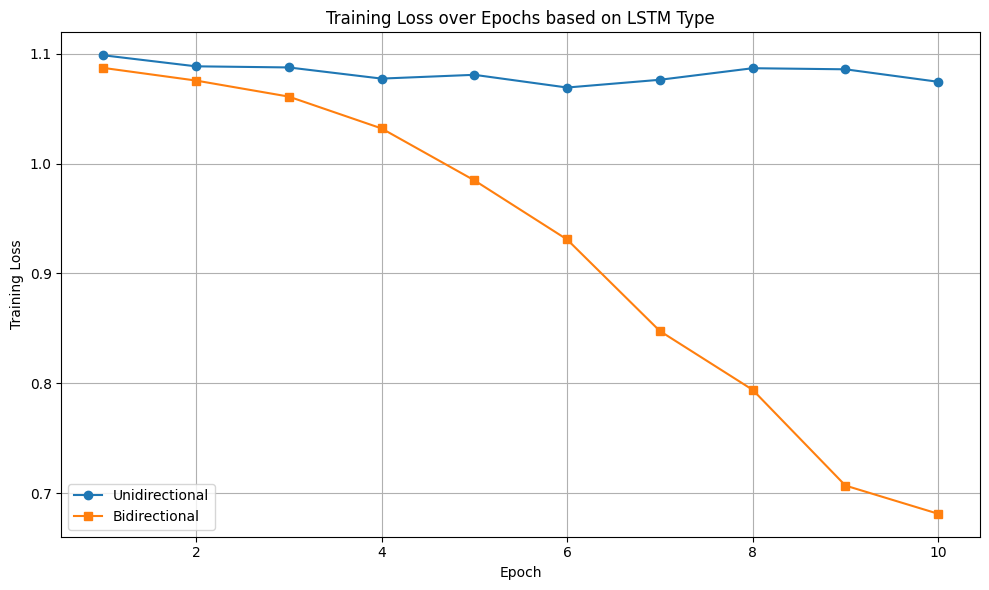

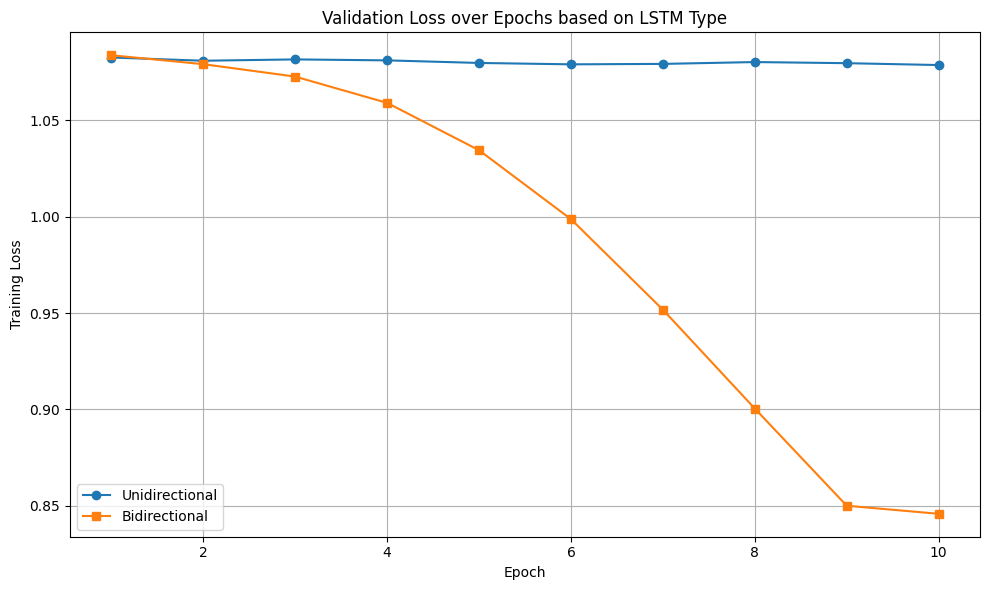

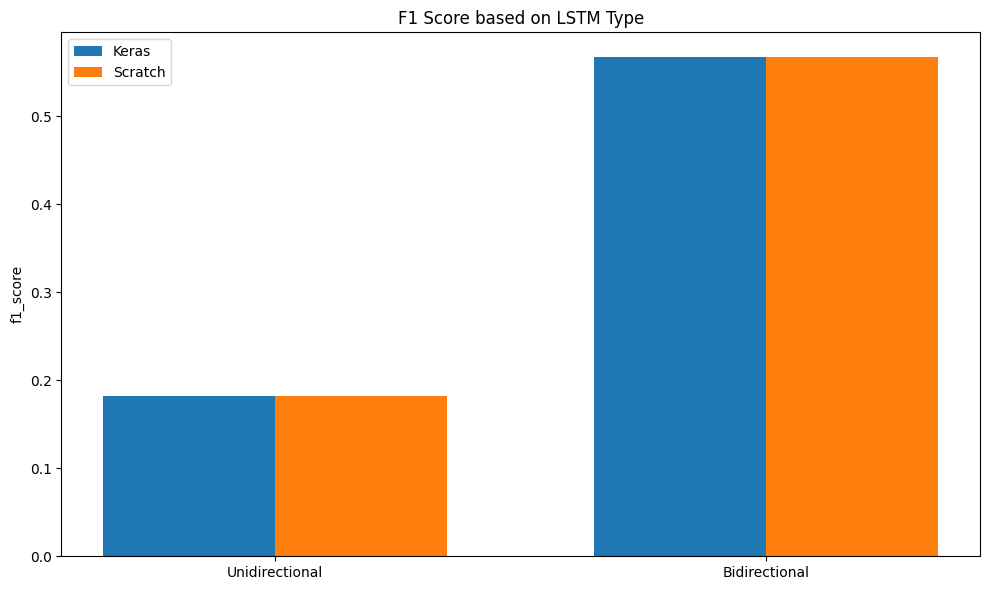

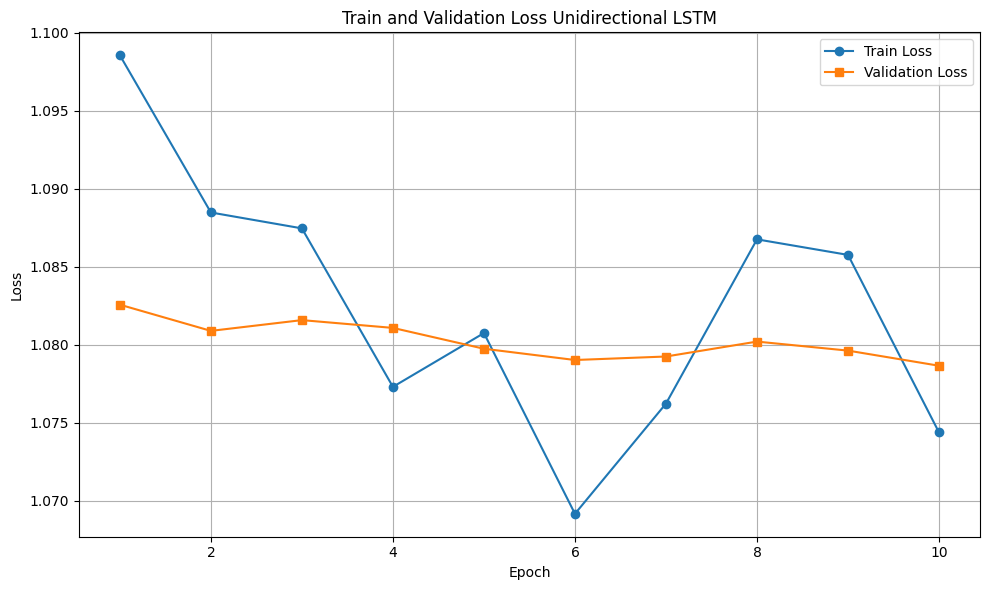

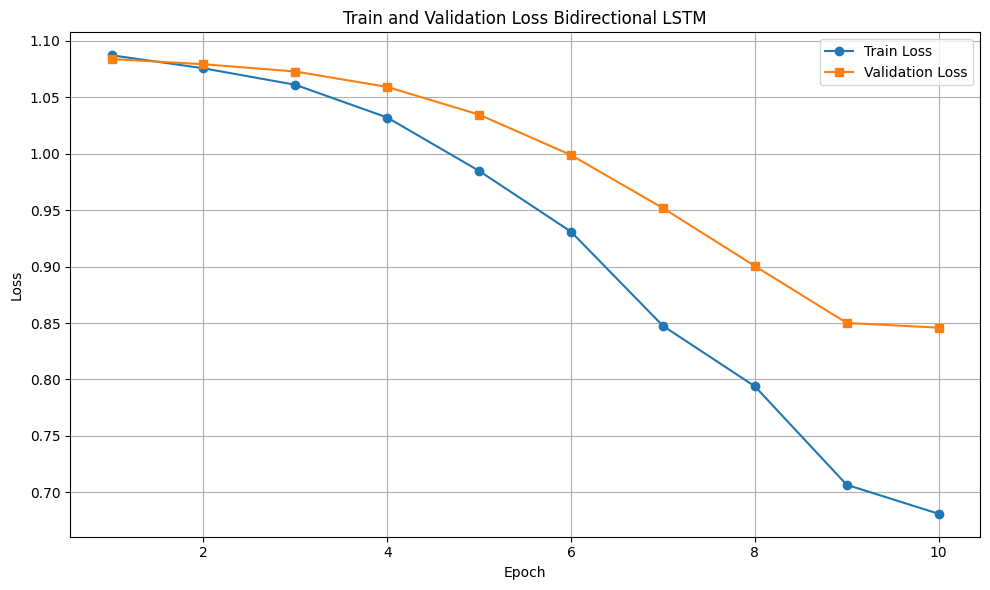

In [29]:
visualize_loss(list(range(1, len(train_loss[0])+1)), train_loss, ['Unidirectional', 'Bidirectional'], 'Training Loss over Epochs based on LSTM Type')
visualize_loss(list(range(1, len(val_loss[0])+1)), val_loss, ['Unidirectional', 'Bidirectional'], 'Validation Loss over Epochs based on LSTM Type')
visualize_f1(scores, scores_scratch, ['Unidirectional', 'Bidirectional'], title='F1 Score based on LSTM Type')
visualize_train_val_loss(train_loss=train_loss[0], val_loss=val_loss[0], epochs=list(range(1, len(train_loss[0])+1)), title='Train and Validation Loss Unidirectional LSTM')
visualize_train_val_loss(train_loss=train_loss[1], val_loss=val_loss[1], epochs=list(range(1, len(train_loss[1])+1)), title='Train and Validation Loss Bidirectional LSTM')

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

# Redefine model using functional API to allow access to .input and .output
print(train_padded.shape)
input_layer = Input(shape=(train_padded.shape[1],))
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)
lstm = Bidirectional(LSTM(units=8, activation='tanh', return_sequences=False))(embedding)
# lstm2 = LSTM(units=8, activation='tanh', return_sequences=False)(lstm)
output = Dense(3, activation='softmax')(lstm)

# Define the full model
model = Model(inputs=input_layer, outputs=output)

# Compile and fit as usual
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_padded, train['label'].values,
          validation_data=(valid_padded, valid['label'].values),
          epochs=10, batch_size=32, verbose=0)

# Now you can get intermediate outputs
intermediate_model = Model(inputs=model.input, outputs=[embedding, lstm, output])
sample_input = train_padded[:1]
outputs = intermediate_model.predict(sample_input)

for i, layer_output in enumerate(outputs):
    print(f"\nLayer {i} Output:")
    print(layer_output)


(500, 60)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

Layer 0 Output:
[[[-0.00493671 -0.00068913  0.04543818 ...  0.07156519  0.02146659
    0.00748637]
  [-0.00423447 -0.07709295  0.00849833 ...  0.05424488  0.07879335
    0.00710206]
  [-0.05138825 -0.08373588  0.02877499 ...  0.01564872  0.04591099
   -0.02627418]
  ...
  [-0.0535359  -0.02145244  0.03015848 ...  0.16451752 -0.06163746
   -0.00075866]
  [-0.0535359  -0.02145244  0.03015848 ...  0.16451752 -0.06163746
   -0.00075866]
  [-0.0535359  -0.02145244  0.03015848 ...  0.16451752 -0.06163746
   -0.00075866]]]

Layer 1 Output:
[[ 0.36859035 -0.15876336  0.09605636 -0.20451067  0.17667711  0.3654955
  -0.20521137 -0.34898546  0.31556362  0.2393796   0.10936351  0.4550073
   0.0933333  -0.3861843  -0.21997657  0.31290996]]

Layer 2 Output:
[[0.6674265  0.09308583 0.23948774]]


In [31]:
from utils.autodiff import Value
print(model.layers[3])  # Embedding layer weights
embeddinglayer = EmbeddingLayer(vocab_size, embedding_dim).load_weights(model.layers[1].get_weights())
output = embeddinglayer(train_padded[:1])
# print("Embedding Layer Output:")
# print(output.data.numpy())


forward = UnidirectionalLSTM(8, return_sequences=True, activation='tanh').load_weights(model.layers[2].get_weights()[:3])  # LSTM has more weights
output_f = forward(output.data)
# print("Unidirectional LSTM Forward Output:")
# print(output_f.data.numpy())

back = UnidirectionalLSTM(8, return_sequences=True, activation='tanh').load_weights(model.layers[2].get_weights()[-3:])  # LSTM backward weights
output_b = back(output.data.flip(dims=[1]))
# print("Unidirectional LSTM Output:")
# print(output_b.data.flip(dims=[1]))
output_b = Value(output_b.data.flip(dims=[1]))
print(Value.cat([output_f, output_b], dim=2).data.numpy())

bidirectional = BidirectionalLSTM(8, return_sequences=True, activation='tanh').load_weights(model.layers[2].get_weights())
output_bi = bidirectional(output.data)
print("Bidirectional LSTM Output:")
print(output_bi.data.numpy())

# model_scratch = LSTMModel([
#     EmbeddingLayer(vocab_size, embedding_dim),
#     UnidirectionalLSTM(8, return_sequences=False, activation='tanh', go_backwards=True),
#     DenseLayer(3, 8, activation='softmax', init_method='zeros')
# ], 32)

<Dense name=dense_8, built=True>
[[[ 1.29561862e-02 -5.86093543e-03 -1.10059744e-02  1.38620744e-04
   -4.82325582e-03 -1.64730959e-02 -1.20035429e-02 -7.86614977e-03
    3.15563679e-01  2.39379585e-01  1.09363556e-01  4.55007315e-01
    9.33333263e-02 -3.86184365e-01 -2.19976619e-01  3.12909991e-01]
  [ 2.24295985e-02 -1.09480217e-03 -1.00759314e-02  3.96616803e-03
    3.49653186e-04 -3.07269283e-02 -1.60408840e-02  1.74445740e-03
    3.19684118e-01  2.23734111e-01  8.18284303e-02  4.27049458e-01
    1.01440080e-01 -3.85218978e-01 -2.51880914e-01  3.17475826e-01]
  [ 3.19866426e-02 -5.13095735e-03  3.49039841e-03  9.90377623e-04
    3.33838002e-03 -2.95921918e-02 -1.29327662e-02 -4.77960706e-03
    3.06649089e-01  1.84508950e-01  8.90611634e-02  3.88768017e-01
    1.15658738e-01 -3.88071269e-01 -2.49718457e-01  3.08072418e-01]
  [ 2.80141216e-02 -2.70088203e-03  2.31848434e-02  1.43191414e-02
    8.42320640e-03 -2.68938057e-02 -3.35215293e-02 -1.63572915e-02
    2.96058089e-01  1.4303

In [32]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional

# Example: assume train_padded and other vars are already defined
# train_padded.shape → (num_samples, sequence_length)
sequence_len = train_padded.shape[1]
sample_input = train_padded[:1]  # pick 1 sample (shape: (1, sequence_len))

# Input layer
input_layer = Input(shape=(sequence_len,))

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)
embedded = embedding_layer(input_layer)

# Bidirectional LSTM with return_sequences=True
lstm_seq = Bidirectional(LSTM(units=8, activation='tanh', return_sequences=True))
lstm_out_seq = lstm_seq(embedded)
model_seq = Model(inputs=input_layer, outputs=lstm_out_seq)

# Build and initialize weights
_ = model_seq.predict(sample_input)

# Bidirectional LSTM with return_sequences=False
lstm_last = Bidirectional(LSTM(units=8, activation='tanh', return_sequences=False))
lstm_out_last = lstm_last(embedding_layer(input_layer))  # use same embedding
model_last = Model(inputs=input_layer, outputs=lstm_out_last)

# Share weights
lstm_last.set_weights(lstm_seq.get_weights())

# Predict
out_seq = model_seq.predict(sample_input)
out_last = model_last.predict(sample_input)

# Print outputs
print("Output with return_sequences=True:")
print(out_seq)

print("\nOutput with return_sequences=False:")
print(out_last)

print("\nMatch last timestep:")
print(np.allclose(out_seq[:, -1, :], out_last, atol=1e-5))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Output with return_sequences=True:
[[[-4.78754612e-03 -1.16938092e-02  9.78159904e-03  2.74647959e-03
    8.07194039e-04  1.28514797e-03  3.72418039e-03 -1.50482124e-03
   -1.31058330e-02  1.86662450e-02 -2.09923764e-03  7.10967416e-03
    2.09587486e-03  3.92070273e-03  1.82443317e-02  4.56977217e-03]
  [-3.34210019e-03  4.81919665e-03  1.76128615e-02  9.21568926e-03
   -6.73973421e-03 -3.37980827e-03 -3.02944391e-04  4.13056975e-03
   -1.51226791e-02  3.78166549e-02 -1.57747827e-02  2.05162559e-02
    2.44015940e-02  1.55119635e-02  1.12447059e-02  1.12128323e-02]
  [-2.40939073e-02  1.37072522e-02  5.09021711e-03 -5.35273366e-03
    1.14559464e-03 -1.10060931e-03  2.64674574e-02  5.03335427e-03
   -1.96657404e-02  3.03678140e-02 -2.38428246e-02  1.51800001e-02
    2.96365824e-02  1.25900432e-02  2.12900508e-02  1.05715608e-02]
  [-3.98105867e-02  4.25134646e-03 -5.8988

In [33]:
from utils.autodiff import Value
# print(model.layers[3])  # Embedding layer weights
embeddinglayer = EmbeddingLayer(vocab_size, embedding_dim).load_weights(embedding_layer.get_weights())
output = embeddinglayer(train_padded[:1])
# print("Embedding Layer Output:")
# print(output.data.numpy())


forward = UnidirectionalLSTM(8, return_sequences=True, activation='tanh').load_weights(lstm_seq.get_weights()[:3])  # LSTM has more weights
output_f = forward(output.data)
# print("Unidirectional LSTM Forward Output:")
print(output_f.data.numpy())

back = UnidirectionalLSTM(8, return_sequences=True, activation='tanh').load_weights(lstm_seq.get_weights()[-3:])  # LSTM backward weights
output_b = back(output.data.flip(dims=[1]))
# print("Unidirectional LSTM Output:")
print(output_b.data.numpy())
# output_b = Value(output_b.data.flip(dims=[1]))
# print(Value.cat([output_f, output_b], dim=2).data.numpy())

bidirectional = BidirectionalLSTM(8, return_sequences=False, activation='tanh').load_weights(lstm_seq.get_weights())
output_bi = bidirectional(output.data)
print("Bidirectional LSTM Output:")
print(output_bi.data.numpy())

# model_scratch = LSTMModel([
#     EmbeddingLayer(vocab_size, embedding_dim),
#     UnidirectionalLSTM(8, return_sequences=False, activation='tanh', go_backwards=True),
#     DenseLayer(3, 8, activation='softmax', init_method='zeros')
# ], 32)

[[[-4.78754705e-03 -1.16938120e-02  9.78160091e-03  2.74648098e-03
    8.07196659e-04  1.28514774e-03  3.72418249e-03 -1.50482100e-03]
  [-3.34210205e-03  4.81919991e-03  1.76128652e-02  9.21569113e-03
   -6.73973234e-03 -3.37980920e-03 -3.02945409e-04  4.13057115e-03]
  [-2.40939092e-02  1.37072569e-02  5.09021943e-03 -5.35273319e-03
    1.14559662e-03 -1.10061059e-03  2.64674649e-02  5.03335427e-03]
  [-3.98105904e-02  4.25134925e-03 -5.89886494e-03 -6.87941350e-03
    1.57639734e-04  1.24187290e-03  3.75856087e-02 -5.56475762e-03]
  [-1.81069355e-02 -5.17768972e-03  1.45175634e-03 -9.49606486e-03
    1.22757042e-02 -9.20804404e-03  3.41644473e-02 -1.79779530e-02]
  [-1.89315956e-02 -1.45120807e-02 -8.53189267e-04 -1.35820797e-02
    6.06017699e-03 -5.80133684e-03  2.13853121e-02 -9.47099295e-04]
  [-1.10449288e-02 -7.92538188e-03  9.09009390e-03  1.07509794e-03
    1.28985792e-02  8.46304279e-03  2.56642178e-02 -2.56146304e-03]
  [-8.07299092e-03 -1.01803550e-02 -5.21083083e-03 -7.2